In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jax.numpy as jnp
from jax import grad

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

from plots import plot_function 

from IPython import display

π = np.pi

# Gradient Descent

We will start with a general convex cost function $f$:

\begin{equation}
f(\mathbf{w}) = \frac{1}{2} \mathbf{w}^{\top} \mathsf{A}\, \mathbf{w}
\end{equation}

where $\mathsf{A} \in \mathbb{R}^{2 \times 2}$ is a positive semi-definite matrix. We want to minimize this function iteratively by making steps *downhill* via **gradient descent**:

\begin{equation}
\mathbf{w}_{i+1} \leftarrow \mathbf{w}_i - \eta \nabla_w f(\mathbf{w}_i).
\end{equation}

In [6]:
# Define the function
def f(w, A):
    return (1/2) * jnp.dot(w.T, jnp.dot(A, w))

# Gradient of the function
df_dw = grad(f, argnums=0)

np.random.seed(10)
# Create a random symmetric positive definite matrix A 
A = np.random.rand(2, 2)
A = jnp.dot(A, A.T)  
A = jnp.array(A)  

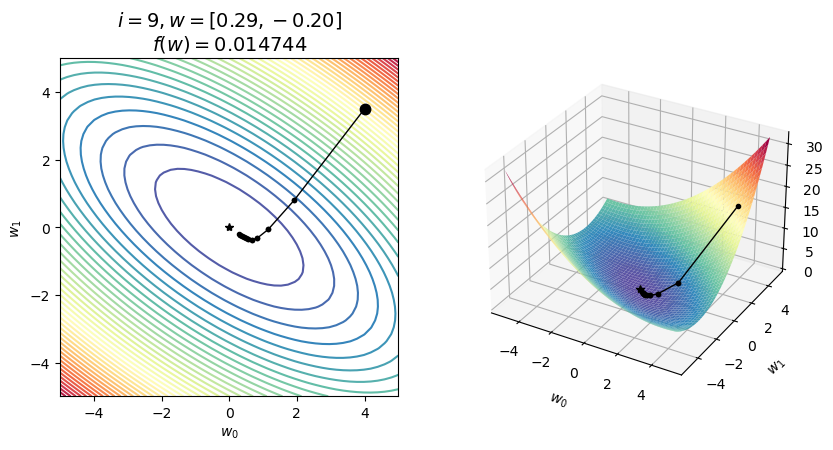

In [7]:
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 50), lambda w: f(w, A))

# hyperparameters
η = 0.5 # learning rate
num_iter = 10 # number of iterations
w = np.array([4.0,3.5]) # initial guess

ax.plot(*w, marker='.', color='k', ms=15)

for i in range(num_iter):

    # we keep a copy of the previous version for plotting
    w_old = np.copy(w)

    # perform the GD update
    w += -η*df_dw(w, A)

    # plot
    ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1)
    ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [f(w_old,A),f(w,A)], marker='.', linestyle='-', color='k',lw=1, zorder=100)

    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {f(w,A):.6f}$', fontsize=14);

    display.display(fig)
    display.clear_output(wait=True)

# Adaptive Methods

## Gradient Descent with Momentum
 We modify our above algorithm to include *momentum* (or memory):

\begin{align}
\mathbf{v}_i &\leftarrow \beta \mathbf{v}_{i-1} + \eta \nabla_w f(\mathbf{w}_i) \\
\mathbf{w}_{i+1} &\leftarrow \mathbf{w}_i - \mathbf{v}_{i} 
\end{align}

where we have a new momentum **hyperparamter** $0 \le \beta < 1$. If $\beta = 0$, we have an ordinary gradient descent. By increasing $\beta$, we increases the information saved from the previous steps.  Note that $\beta \approx 0.9$ gives us a memory of approximately 10 iterations. 

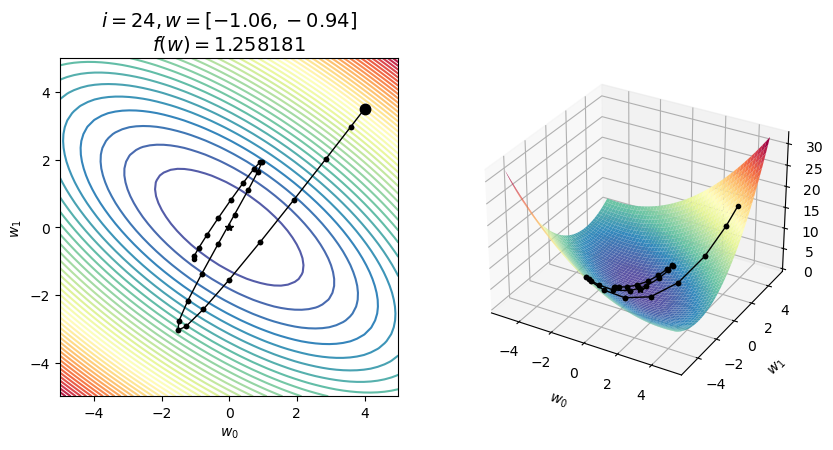

In [15]:
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 50), lambda x: f(x, A))

# hyperparameters
η = 0.1
β  = 0.9
num_iter = 25

w = np.array([4.0,3.5])
v = np.zeros(2)

ax.plot(*w, marker='.', color='k', ms=15)  

for i in range(num_iter):
    
    # keep a copy for plotting
    w_old = np.copy(w)
    
    # perform the CM update
    v = β*v + η*df_dw(w, A)
    w -= v
    
    # plot
    ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1) 
    ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [f(w_old,A),f(w,A)], marker='.', linestyle='-', color='k',lw=1, zorder=100)

    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {f(w,A):.6f}$', fontsize=14);
    display.display(fig)
    display.clear_output(wait=True)


## ADAM
We will use the first and second moment of the gradient to update the learning rate for different parameters. We have

\begin{align}
\mathbf{g}_i &= \nabla_w f(\mathbf{w}_i) \\
\mathbf{m}_i &= \beta_1 \mathbf{m}_{i-1} + (1-\beta_1) \mathbf{g}_i \\
\mathbf{v}_i &= \beta_2 \mathbf{v}_{i-1} +(1-\beta_2)\mathbf{g}_i^2  \\
\hat{\mathbf{m}}_i &= \frac{\mathbf{m}_i}{1-(\beta_1)^i} \\
\hat{\mathbf{v}}_i &= \frac{\mathbf{v}_i}{1-(\beta_2)^i}  \\
\mathbf{w}_{i+1} &=\mathbf{w}_i - \eta \frac{\hat{\mathbf{m}}_i}{\sqrt{\hat{\mathbf{v}}_i} +\epsilon}, \nonumber 
\end{align}


where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment.  

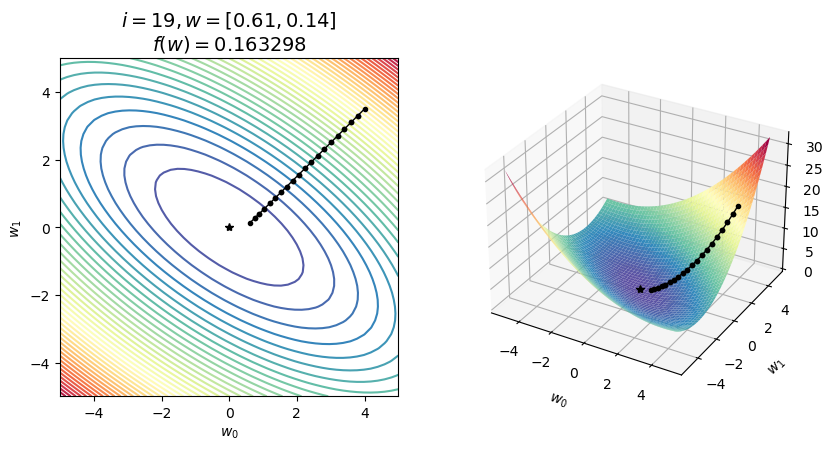

In [21]:
β1 = 0.9
β2 = 0.999
ϵ = 1.0E-8
η = 0.2

num_iter = 20

ax.plot(*w, marker='.', color='k', ms=15)

w = np.array([4.0,3.5])

w_traj = np.zeros([num_iter,2])
w_traj[0,:] = w
fig, ax, ax3d = plot_function(np.linspace(-5, 5, 50), lambda x: f(x, A))

m = np.zeros(2)
v = np.zeros(2)

for i in range(1,num_iter):

    g = np.array(df_dw(w,A))
    m = β1*m + (1-β1)*g
    v = β2*v + (1-β2)*g*g

    m̂ = m/(1-β1**i)
    v̂ = v/(1-β2**i)

    w_old = np.copy(w)

    w = w - η*np.divide(m̂,np.sqrt(v̂) + ϵ)

    # plot
    ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1)
    ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [f(w_old,A),f(w,A)], marker='.', linestyle='-', color='k',lw=1, zorder=100)

    ax.set_title(f'$i={i}, w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$f(w) = {f(w,A):.6f}$', fontsize=14);

    display.display(fig)
    display.clear_output(wait=True)


# Stochastic Gradient Descent

## Fitting Sample Data

First, let's look at our data.

Text(0, 0.5, 'y')

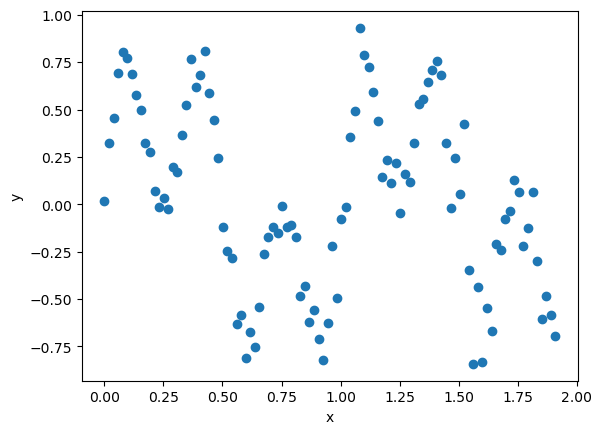

In [22]:
x, y = np.loadtxt('sample.txt', unpack=True)

plt.plot(x,y, 'o')
plt.xlabel('x')
plt.ylabel('y')

We want to minimize the cost function: 

\begin{equation}
\mathcal{C} = \frac{1}{2N} \sum_{n=1}^N  \left( F^{(n)} - y^{(n)} \right)^2 = \frac{1}{2N} \lvert \lvert \vec{F} - \vec{y}\rvert\rvert^2
\end{equation}

which measures the difference between some data set $\{(x^{(n)},y^{(n)})\}_{n=1}^N$ to some proposed model $F$. Here, we guess that the our predicted model is of the form $F(x)=\cos(w_0x)\sin(w_1x)$. We want to find $w_0$ and $w_1$ that will minimize our cost function.

In [23]:
#predicted model
def F(x,w):
    return jnp.cos(w[0]*x)*jnp.sin(w[1]*x)

#cost function
def C(w,x,y):
    return 0.5*jnp.average((F(x,w)-y)**2)

dC_dw = grad(C,argnums=0)

## Gradient Descent 

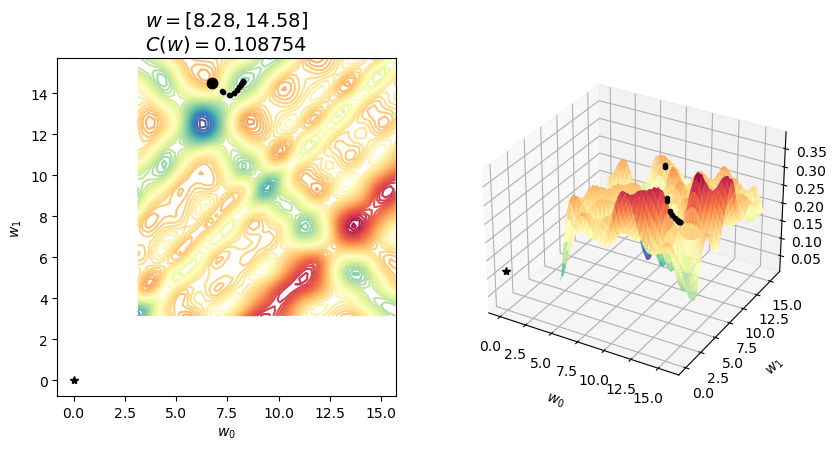

In [24]:
fig, ax, ax3d = plot_function(np.linspace(π,5*π, 50), lambda w: C(w,x,y))

# hyperparameters
η = 0.5
num_iter = 100

# let's start near the minimum
w = np.array([6.75,14.5])

# store the cost function during the trajectory
C_traj = {}
C_traj['GD'] = np.zeros([num_iter])

ax.plot(*w, marker='.', color='k', ms=15)  

for i in range(num_iter):

    # we keep a copy of the previous version for plotting
    w_old = np.copy(w)
    C_traj['GD'][i] = C(w,x,y)
    
    # perform the GD update
    w += -η*dC_dw(w,x,y)
    
    # plot
# plot
    if i % 10 == 0:
        ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1)
        ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [C(w_old,x,y),C(w,x,y)], marker='.', linestyle='-', color='k',lw=1, zorder=100)
        ax.set_title(fr'$w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$C(w) = {C(w,x,y):.6f}$', fontsize=14);
        display.display(fig)
        display.clear_output(wait=True)

w_GD = w

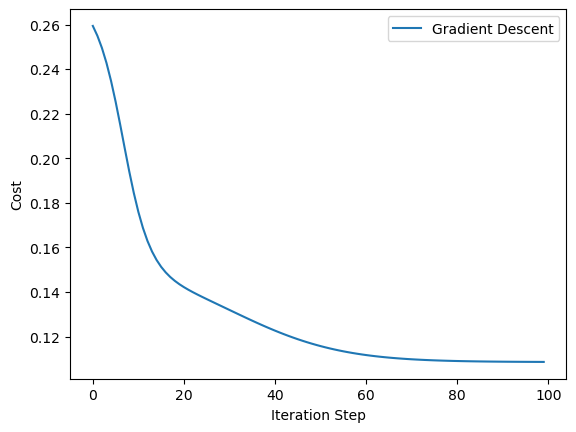

In [25]:
plt.plot(C_traj['GD'], label='Gradient Descent')
plt.xlabel('Iteration Step')
plt.ylabel('Cost')
plt.legend()

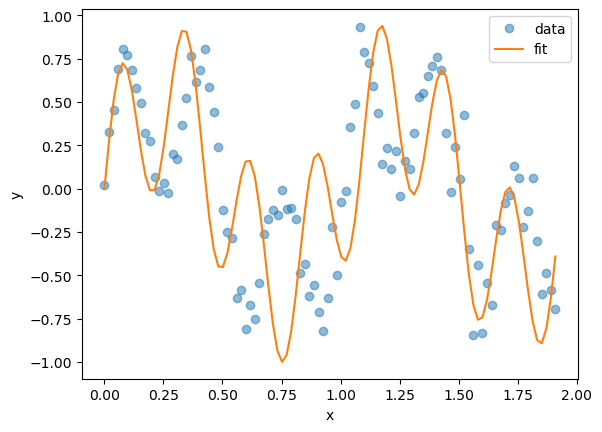

In [26]:
plt.plot(x,y, 'o', label='data', alpha=0.5)
plt.plot(x,F(x,w),'-', label='fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Stochastic Gradient Descent

In [27]:
N = x.size #samples
NB = 5 # minibatch size
idx = np.random.choice(N, NB, replace=False) #choosing random indices

print(f'Number of samples:', N)
print(f'Random indices:', idx)

Number of samples: 100
Random indices: [85 35 48 47 82]


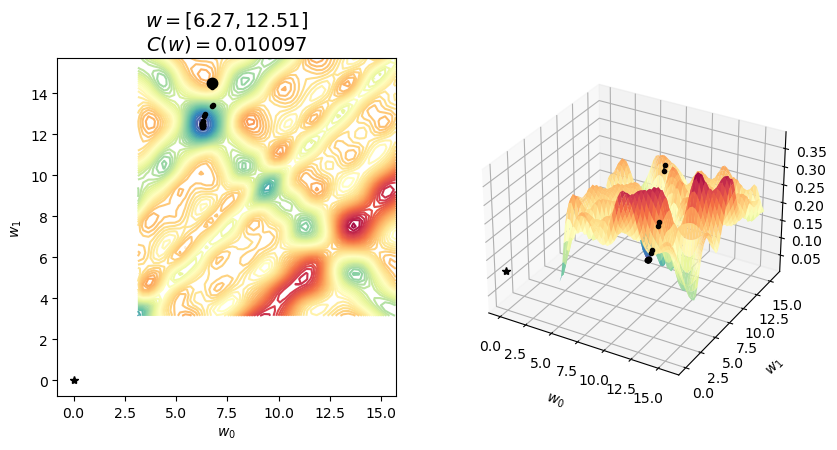

In [28]:
# hyperparameters
η = 0.5
w = np.array([6.75,14.5])

num_epoch = 5
num_batch = int(N/NB)

C_traj['SGD'] = np.zeros([num_epoch*num_batch])

fig, ax, ax3d = plot_function(np.linspace(π,5*π, 50), lambda w: C(w,x,y))

ax.plot(*w, marker='.', color='k', ms=15)

# each epoch includes all minibatches
i = 0
for epoch in range(num_epoch):
    for batch in range(num_batch):

        # get the batch
        idx = np.random.choice(N, NB, replace=False)

        # we keep a copy of the previous version for plotting
        w_old = np.copy(w)
        C_traj['SGD'][i] = C(w,x,y)

        # perform the stocahstic GD update
        w += -η*dC_dw(w,x[idx],y[idx])
    
        # plot
        if i % 10 == 0:

            ax.plot([w_old[0], w[0]], [w_old[1], w[1]], marker='.', linestyle='-', color='k',lw=1)
            ax3d.plot([w_old[0], w[0]], [w_old[1], w[1]], [C(w_old,x,y),C(w,x,y)], marker='.', linestyle='-', color='k',lw=1, zorder=100)

            ax.set_title(fr'$w=[{w[0]:.2f},{w[1]:.2f}]$' + '\n' + f'$C(w) = {C(w,x,y):.6f}$', fontsize=14);
            display.display(fig)
            display.clear_output(wait=True)
        i += 1

w_SGD = w

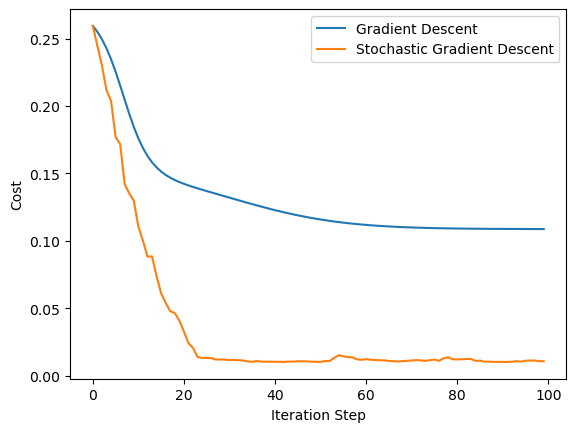

In [29]:
plt.plot(C_traj['GD'], label='Gradient Descent')
plt.plot(C_traj['SGD'], label='Stochastic Gradient Descent')

plt.xlabel('Iteration Step')
plt.ylabel('Cost')
plt.legend()

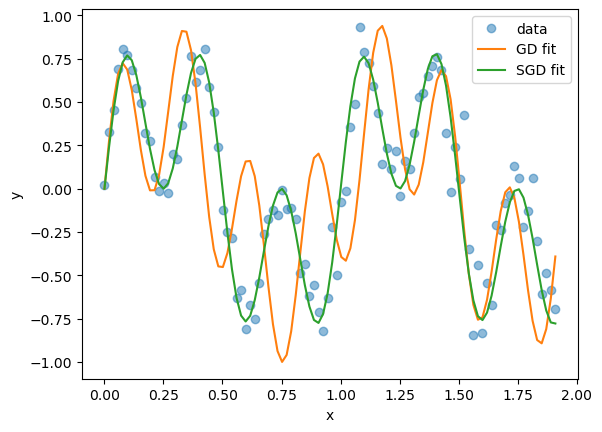

In [30]:
plt.plot(x,y, 'o', label='data', alpha=0.5)
plt.plot(x,F(x,w_GD),'-', label='GD fit')
plt.plot(x,F(x,w_SGD),'-', label='SGD fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()